# Predict Bike Sharing Demand with AutoGluon Template

### Install packages

In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon==0.2.0 --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [3]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "barbarastefanovska"
kaggle_key = "51cb4dd5e050a7961bcfd9b179fe5d05"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

In [5]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0%|                                                | 0.00/189k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 189k/189k [00:00<00:00, 8.86MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [6]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [7]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv", parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

In [9]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv", parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [10]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv", parse_dates=['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [11]:
predictor = TabularPredictor(
    label="count", 
    eval_metric = 'root_mean_squared_error',
    verbosity=1,
    learner_kwargs={"ignored_columns": ["casual", "registered"]}
).fit(
    train_data=train,
    time_limit=600, 
    presets="best_quality"
)

### Review AutoGluon's training run with ranking of models that did the best.

In [12]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -103.341495       5.701579  545.715793                0.001245           0.964800            3       True         19
1   NeuralNetFastAI_BAG_L2 -104.010693       4.747923  460.377866                0.359927          84.906963            2       True         18
2        LightGBMXT_BAG_L2 -104.596532       4.747534  390.544372                0.359539          15.073470            2       True         13
3          CatBoost_BAG_L2 -104.888636       4.408182  411.462105                0.020186          35.991202            2       True         16
4          LightGBM_BAG_L2 -105.498424       4.485571  383.403239                0.097575           7.932336            2       True         14
5     ExtraTreesMSE_BAG_L2 -106.556898       4.860673  381.608950         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'KNeighborsUnif_BAG_L2': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L2': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  '

### Create predictions from test dataset

In [25]:
predictions = predictor.predict(test)
predictions.head()

0    74.685448
1    73.692406
2    73.693192
3    85.015442
4    85.010803
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [26]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      185.755432
std       126.946510
min       -31.216183
25%        84.262581
50%       159.175430
75%       264.600159
max       676.822449
Name: count, dtype: float64

In [27]:
# How many negative values do we have?
predictions[predictions<0]
predictions[predictions<0].count()

22

In [28]:
# Set them to zero
predictions[predictions<0] = 0

### Set predictions to submission dataframe, save, and submit

In [29]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [30]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 396kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [31]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description           status    publicScore  privateScore  
--------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv  2023-01-13 03:09:13  first raw submission  complete  1.36777      1.36777       


#### Initial score of `?`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>],
       [<AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>]], dtype=object)

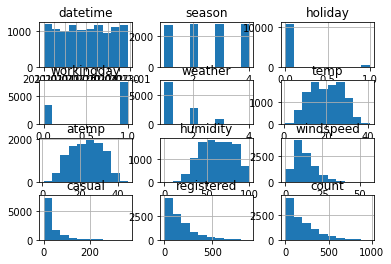

In [32]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

In [34]:
# create a new feature
#Split Datetime into -> hour day month
train['hour'] = train['datetime'].dt.hour
train['day'] = train['datetime'].dt.day
train['month'] = train['datetime'].dt.month

test['hour'] = test['datetime'].dt.hour
test['day'] = test['datetime'].dt.day
test['month'] = test['datetime'].dt.month

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [51]:
train["weather"] = train["weather"].astype('category')
train["holiday"] = train["holiday"].astype('category')
train["workingday"] = train["workingday"].astype('category')
train["hour"] = train["hour"].astype('category')
train["month"] = train["month"].astype('category')
test["weather"] = test["weather"].astype('category')
test["holiday"] = test["holiday"].astype('category')
test["workingday"] = test["workingday"].astype('category')
test["hour"] = test["hour"].astype('category')
test["month"] = test["month"].astype('category')

In [52]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1,1


array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'atemp'}>],
       [<AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'casual'}>],
       [<AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>,
        <AxesSubplot:title={'center':'day'}>]], dtype=object)

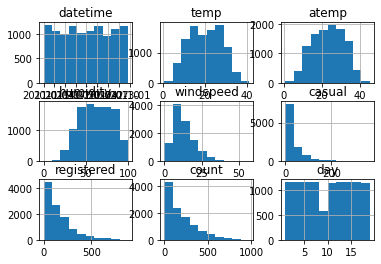

In [53]:
# View histogram of all features again now with the hour feature
train.hist()

## Step 5: Rerun the model with the same settings as before, just with more features

In [54]:
predictor_new_features = TabularPredictor(
    label="count", 
    eval_metric = 'root_mean_squared_error',
    verbosity=0,
    learner_kwargs={"ignored_columns": ["casual", "registered"]}
).fit(
    train_data=train,
    time_limit=600, 
    presets="best_quality"
)

In [55]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2  -36.842564       3.280902  337.361198                0.001306           0.967604            2       True          9
1      WeightedEnsemble_L3  -36.930946       5.163606  487.986377                0.001292           0.945958            3       True         18
2   NeuralNetFastAI_BAG_L2  -37.105222       4.392227  445.188986                0.498991         104.809912            2       True         17
3          CatBoost_BAG_L2  -37.322248       3.995482  375.554507                0.102246          35.175433            2       True         15
4     ExtraTreesMSE_BAG_L2  -37.420491       4.358105  347.021250                0.464869           6.642177            2       True         16
5          LightGBM_BAG_L2  -37.884740       4.008742  347.813376         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'KNeighborsUnif_BAG_L2': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L2': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'mode

In [57]:
# Get Features
predictions_new_features = predictor_new_features.predict(test)

/usr/local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/usr/local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [60]:
#Set negative values to zero
predictions_new_features[predictions_new_features<0].count()
predictions_new_features[predictions_new_features<0] = 0

In [63]:
# Same submitting predictions
#submission_new_features = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'])
submission_new_features = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'])
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [64]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 391kB/s]
Successfully submitted to Bike Sharing Demand

In [65]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2023-01-13 04:02:55  new features          complete  0.51086      0.51086       
submission.csv               2023-01-13 03:09:13  first raw submission  complete  1.36777      1.36777       


#### New Score of `?`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [66]:
import autogluon.core as ag

In [118]:
#Hyperparametar values for Neral Networks
nn_options = {
    'num_epochs': 15,
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),
    'layers': ag.space.Categorical([100],[1000],[200,100],[300,200,100]),
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),
}

#Hyperparametar values for lightGBM gradient boosted trees
gbm_options = {
    'num_boost_round': 100,
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36)
}

hyperparameters = {
    'GBM': gbm_options,
    'CAT': {'iterations': 15000},
    'RF': {'n_estimators': 500},
    'XT': {'n_estimators': 500},
    'NN': nn_options,
} 


In [119]:
predictor_new_hpo = TabularPredictor(
 label = "count", 
 eval_metric = "root_mean_squared_error",
 learner_kwargs = {"ignored_columns":["casual", "registered"]}
).fit(
    train_data = train, 
    time_limit = 600, 
    presets = "best_quality", 
    hyperparameters = hyperparameters, 
    #hyperparameter_tune_kwargs = "auto",
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230113_053043/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230113_053043/"
AutoGluon Version:  0.2.0
Train Data Rows:    10886
Train Data Columns: 14
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1481.61 MB
	Train Data (Original)  Memory Usage: 0.59 MB (0.0% of availa

KeyboardInterrupt: 

In [120]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                    model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L3  -38.909780       4.274982  230.940595                0.001346           0.628961            3       True         11
1         CatBoost_BAG_L2  -39.148377       3.810778  224.771612                0.114383          83.861534            2       True          8
2       ExtraTrees_BAG_L2  -39.378598       4.159253  146.450099                0.462858           5.540022            2       True          9
3     WeightedEnsemble_L2  -39.836215       0.959855   18.699222                0.001319           0.508001            2       True          5
4         LightGBM_BAG_L2  -39.991295       3.811704  145.260850                0.115309           4.350773            2       True          6
5     RandomForest_BAG_L2  -40.152576       4.155296  159.878349                

{'model_types': {'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForest_BAG_L1': 'StackerEnsembleModel_RF',
  'ExtraTrees_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetMXNet_BAG_L1': 'StackerEnsembleModel_TabularNeuralNet',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForest_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTrees_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetMXNet_BAG_L2': 'StackerEnsembleModel_TabularNeuralNet',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM_BAG_L1': -44.13820539109653,
  'RandomForest_BAG_L1': -41.29633966117901,
  'ExtraTrees_BAG_L1': -41.02854446686698,
  'NeuralNetMXNet_BAG_L1': -128.48830327267123,
  'WeightedEnsemble_L2': -39.83621493532375,
  'LightGBM_BAG_L2': -39.991294554744,
  'RandomForest_BAG_L2': -40.152575885157646,
  'CatBoost_BAG_L2': -39.14837739425049,
  'ExtraTrees_BAG_L2': 

In [121]:
# Get Features
predictions_new_hpo = predictor_new_hpo.predict(test)

/usr/local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/usr/local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [122]:
predictions_new_hpo[predictions_new_hpo<0] = 0

In [123]:
# Same submitting predictions
submission_new_hpo = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'])
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [124]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 328kB/s]
Successfully submitted to Bike Sharing Demand

In [125]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2023-01-13 05:39:11  new features with hyperparameters  complete  0.47601      0.47601       
submission_new_hpo.csv       2023-01-13 05:20:38  new features with hyperparameters  complete  0.47601      0.47601       
submission_new_hpo.csv       2023-01-13 05:07:11  new features with hyperparameters  complete  0.49178      0.49178       
submission_new_features.csv  2023-01-13 04:02:55  new features                       complete  0.51086      0.51086       


#### New Score of `?`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

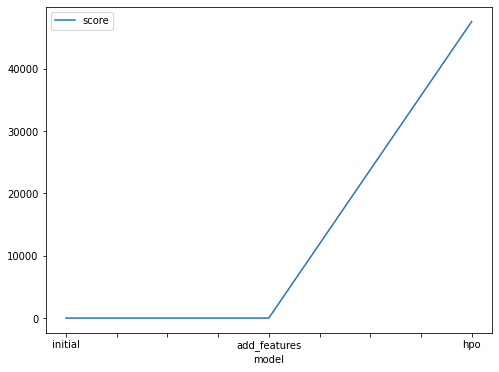

In [126]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [ 1.36777, 0.51086, 47601 ]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

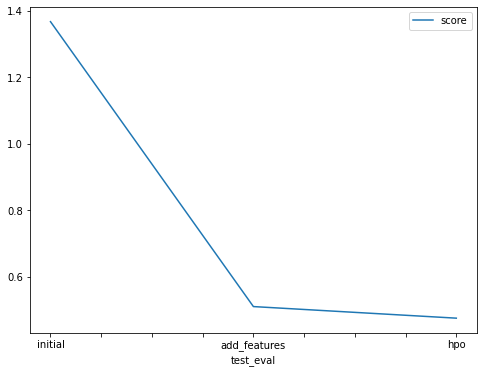

In [127]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [ 1.36777, 0.51086, 0.47601 ]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [130]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ["dafault","default", " 'CAT': iterations:15000, 'RF': n_estimators:500 'XT: n_estimators:500'" ],
    "hpo2": ["default","default", "GB: num_boost_round=100, num_leaves(lower=26, upper=66, default=36)"],
    "hpo3": ["default","default", "hyperparameter_tune_kwargs = 'auto'"],
    "score": [ 1.36777, 0.51086, 0.47601 ]
})

,model,hpo1,hpo2,hpo3,score
0,initial,dafault,default,default,1.36777
1,add_features,default,default,default,0.51086
2,hpo,"'CAT': iterations:15000, 'RF': n_estimators:500 'XT: n_estimators:500'","GB: num_boost_round=100, num_leaves(lower=26, upper=66, default=36)",hyperparameter_tune_kwargs = 'auto',0.47601
